<a href="https://colab.research.google.com/github/wisnudj/H8_PTP_Final_Image/blob/master/CatDog-Classifications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import numpy as np
from PIL import Image
import pathlib
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [121]:
 print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [122]:
tf.__version__

'2.0.0'

In [123]:
 tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load Dataset

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [125]:
PATH

'/root/.keras/datasets/cats_and_dogs_filtered'

In [126]:
path_to_zip

'/root/.keras/datasets/cats_and_dogs.zip'

In [127]:
!ls /root/.keras/datasets/cats_and_dogs_filtered

train  validation  vectorize.py


## Prepare Train and Validation *Dataset*

In [ ]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [ ]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [ ]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [131]:
print("Result split dataset overview:")
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)


Result split dataset overview:
total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [ ]:

batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [ ]:
# Setting data augmentation agar data bervariasi
# rescale berarti gambar di konvert ke format antara 0 - 1
# rotation 45 berarti data gambar akan secara random dirotasi 45 derajat
# width_shift_range dan horizontal_flip data gambar akan di shift secara random
# horizontal_flip berarti gambar akan secara random di flip
# zoom range data secara random akan di zoom

train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5

) # Generator for our training data
validation_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5
) # Generator for our validation data

In [145]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [146]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


In [ ]:
sample_training_images, _ = next(train_data_gen)

In [ ]:
# fungsi ini akan plot gambar dalam 1 row dan 5 kolom dimana setiap kolom terdapat gambar
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

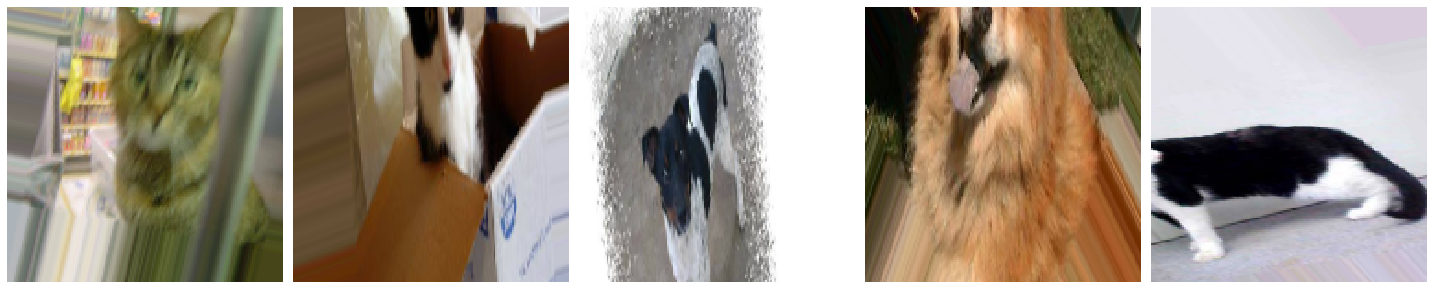

In [149]:
plotImages(sample_training_images[:5])

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(1)
])


In [ ]:
model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [152]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 20736)           

In [153]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=np.ceil(total_train/batch_size),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=np.ceil(total_val/batch_size)
)

Epoch 1/15
16/16 [==============================] - 45s 3s/step - loss: 1.0012 - accuracy: 0.5025 - val_loss: 0.6953 - val_accuracy: 0.5000
Epoch 2/15
16/16 [==============================] - 33s 2s/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6879 - val_accuracy: 0.5000
Epoch 3/15
16/16 [==============================] - 20s 1s/step - loss: 0.6890 - accuracy: 0.5015 - val_loss: 0.6800 - val_accuracy: 0.5000
Epoch 4/15
16/16 [==============================] - 20s 1s/step - loss: 0.6749 - accuracy: 0.5320 - val_loss: 0.6660 - val_accuracy: 0.5100
Epoch 5/15
16/16 [==============================] - 20s 1s/step - loss: 0.6494 - accuracy: 0.5670 - val_loss: 0.6287 - val_accuracy: 0.5970
Epoch 6/15
16/16 [==============================] - 20s 1s/step - loss: 0.6330 - accuracy: 0.6265 - val_loss: 0.6754 - val_accuracy: 0.5430
Epoch 7/15
16/16 [==============================] - 20s 1s/step - loss: 0.6316 - accuracy: 0.6110 - val_loss: 0.6384 - val_accuracy: 0.5960
Epoch 8/15
16/16 [==

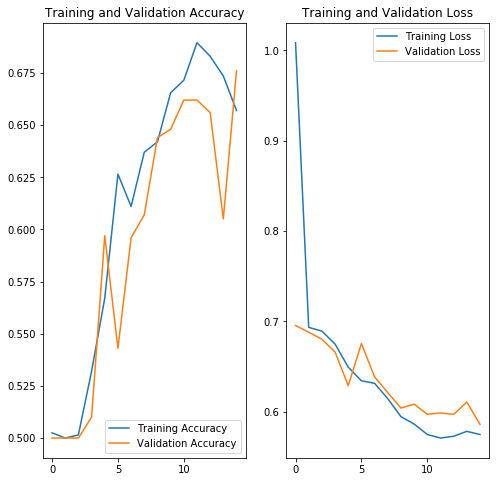

In [154]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
